[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   

           preprocessed_text  
0   im get borderland murder  
1           come border kill  
2     im get borderland kill  
3  im come borderland murder  
4   im get borderland murder  
Feature Matrix Shape: (60401, 5000), Target Vector Shape: (60401,)
Accuracy: 0.7814
Predicted sentiment: Irrelevant
Predicted sentiment: Positive
Predicted sentiment: Neutral
Predicted sentiment: Irrelevant


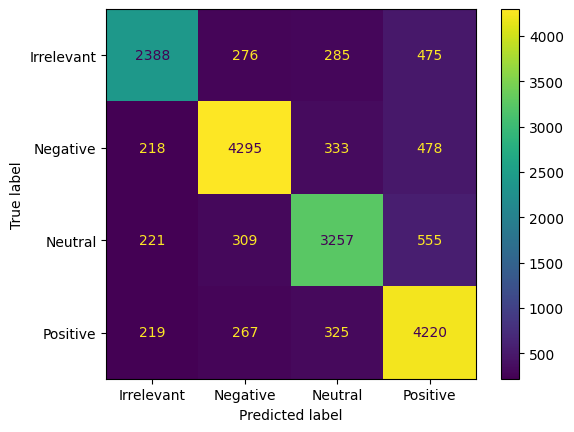

In [29]:
import os
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# Function to list all files in a directory
def list_files_in_directory(directory):
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            print(os.path.join(dirname, filename))

# List files in /kaggle/input directory
list_files_in_directory('/kaggle/input')

# Function to load data
def load_data(filepath, column_names):
    data = pd.read_csv(filepath, names=column_names)
    data.drop('id', axis=1, inplace=True)
    data.dropna(inplace=True)
    return data

# Define column names and load data
column_names = ['id', 'topic', 'sentiment', 'text']
data = load_data('/content/twitter_training.csv', column_names)

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Initialize the stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation, numbers, and special characters
    text = text.lower()  # Convert to lowercase
    tokens = text.split()  # Tokenize the text
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]  # Remove stop words and do stemming
    return ' '.join(tokens)

# Apply text preprocessing
data['preprocessed_text'] = data['text'].apply(preprocess_text)
print(data[['text', 'preprocessed_text']].head())

# Function to extract features using TF-IDF vectorizer
def extract_features(text_data, max_features=5000):
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(text_data)
    return X, vectorizer

# Extract features from preprocessed text
X, vectorizer = extract_features(data['preprocessed_text'])
y = data['sentiment']
print(f'Feature Matrix Shape: {X.shape}, Target Vector Shape: {y.shape}')

# Function to split data into training and testing sets
def split_data(X, y, test_size=0.3):
    return train_test_split(X, y, test_size=test_size, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = split_data(X, y)

# Function to train a Decision Tree Classifier
def train_classifier(X_train, y_train):
    clf = DecisionTreeClassifier(criterion='gini', splitter='random', random_state=42)
    clf.fit(X_train, y_train)
    return clf

# Train a Decision Tree Classifier on the training data
clf = train_classifier(X_train, y_train)

# Function to evaluate the classifier
def evaluate_classifier(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

# Evaluate the classifier on the testing data
evaluate_classifier(clf, X_test, y_test)

# Function to predict sentiment for new texts
def predict_sentiment(text, clf, vectorizer):
    preprocessed_text = preprocess_text(text)
    X_new = vectorizer.transform([preprocessed_text])
    predicted_sentiment = clf.predict(X_new)
    print(f"Predicted sentiment: {predicted_sentiment[0]}")

# Test the predict_sentiment function with sample texts
sample_texts = [
    "I am feeling very happy today",
    "It's beyond me",
    "Die, you son of something",
    "Nvidia is a Giant Company"
]

for text in sample_texts:
    predict_sentiment(text, clf, vectorizer)
